In [50]:
import numpy as np
import pandas as pd
# from pandas import Series, DataFrame 
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

# from xgboost import XGBClassifier
import lightgbm as ltb
# from catboost import CatBoostClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [27]:
df=pd.read_csv("data\step1.csv")

In [28]:
df.head()

,Unnamed: 0,LEVEL,POSITION,TECH_STACK,EXPERIENCE,GENDER,COMPANY,COMPANY_SIZE,WORK_TYPE,CITY,CURRENCY,SALARY_FOR_OTHER_CURRENCY,SALARY_FOR_TL_CURRENCY,MIN_TL,MAX_TL,CUR_MIN,CUR_MAX
0,0,Middle,BACK-END DEVELOPER,Php,3 - 5 Yıl,Erkek,Startup,25 - 50 Kişi,Hibrit,İstanbul,₺ - Türk Lirası,NaN,15.000 TL - 15.999 TL,15000.0,15999.0,0.0,0.0
1,1,Junior,FRONT-END DEVELOPER,React,0 - 1 Yıl,Erkek,Startup,10 - 25 Kişi,Hibrit,İstanbul,₺ - Türk Lirası,NaN,8.000 TL - 8.999 TL,8000.0,8999.0,0.0,0.0
2,2,Middle,BACK-END DEVELOPER,.Net,1 - 3 Yıl,Erkek,Outsource,10 - 25 Kişi,Remote,İstanbul,₺ - Türk Lirası,NaN,15.000 TL - 15.999 TL,15000.0,15999.0,0.0,0.0
3,3,Junior,FULL STACK DEVELOPER,"Java, JavaScript | Html | Css, React, React Na...",1 - 3 Yıl,Erkek,Startup,10 - 25 Kişi,Hibrit,İstanbul,₺ - Türk Lirası,NaN,10.000 TL - 10.999 TL,10000.0,10999.0,0.0,0.0
4,4,Junior,BACK-END DEVELOPER,".Net, JavaScript | Html | Css",0 - 1 Yıl,Erkek,Kurumsal,250+,Geçici Hibrit,Kocaeli,₺ - Türk Lirası,NaN,5.000 TL - 5.999 TL,5000.0,5999.0,0.0,0.0


In [29]:
# Gereksiz bir değişken var, silelim
df.drop('Unnamed: 0', axis=1, inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5026 entries, 0 to 5025
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LEVEL                      5026 non-null   object 
 1   POSITION                   5026 non-null   object 
 2   TECH_STACK                 5025 non-null   object 
 3   EXPERIENCE                 5026 non-null   object 
 4   GENDER                     5026 non-null   object 
 5   COMPANY                    5026 non-null   object 
 6   COMPANY_SIZE               5026 non-null   object 
 7   WORK_TYPE                  5026 non-null   object 
 8   CITY                       5026 non-null   object 
 9   CURRENCY                   5026 non-null   object 
 10  SALARY_FOR_OTHER_CURRENCY  533 non-null    object 
 11  SALARY_FOR_TL_CURRENCY     4493 non-null   object 
 12  MIN_TL                     5026 non-null   float64
 13  MAX_TL                     5026 non-null   float

In [31]:
def grab_col_names(dataframe, cat_th=15, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat


In [32]:
cat_cols, num_cols, cat_but_car, num_but_cat= grab_col_names(df)

Observations: 5026
Variables: 16
cat_cols: 11
num_cols: 2
cat_but_car: 3
num_but_cat: 2


In [59]:
# Hedef değişken
target_col = "SALARY_AVG_TL"

In [33]:
def cat_summary(dataframe, col_name, plot=True):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe) #gorsellestirmek istiyorsak yukarıdaki "plot=False"u True yaparız
        plt.show()

In [62]:

# for col in cat_cols:
#    cat_summary(df, col)


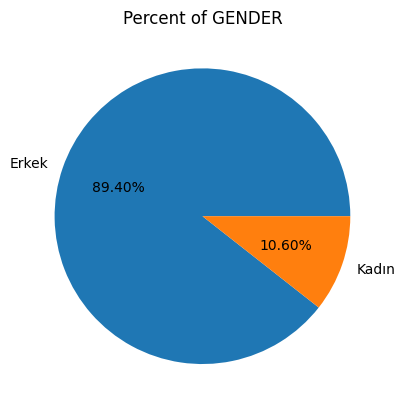

In [8]:
#GENDER daire grafigi yüzdelik
labels = ("Erkek", "Kadın")
sizes = [4497/5030, 533/5030]
plt.pie(sizes, labels=labels, autopct='%1.2f%%')
plt.title("Percent of GENDER")
plt.show()

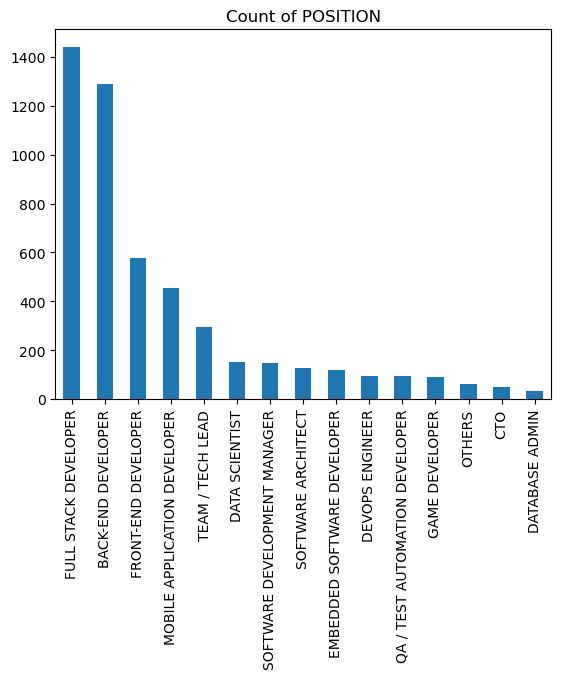

In [13]:
#POSITION SAYILARININ DAĞILIMI

df["POSITION"].value_counts().plot(kind='bar')
plt.title("Count of POSITION")
plt.show(block=True)


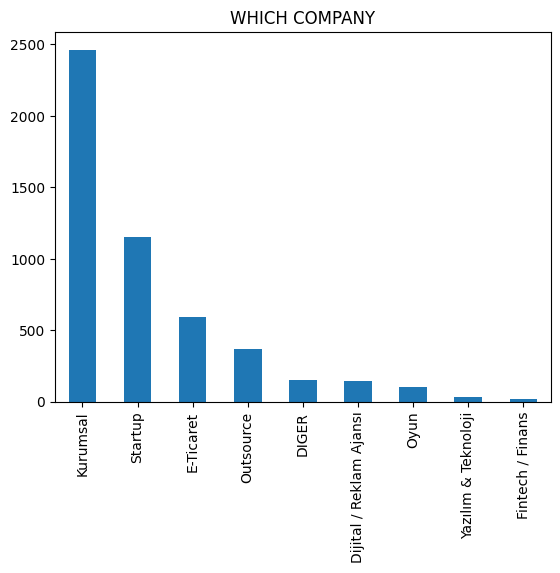

In [16]:
df["COMPANY"].value_counts().plot(kind="bar")
plt.title("WHICH COMPANY")
plt.show(block=True)

In [10]:
#WORK_TYPE LEVEL KIRILIMINDA DEĞERLERİ
df.groupby(["WORK_TYPE", "LEVEL"]).agg({"LEVEL": "count"})

LEVEL
WORK_TYPE     LEVEL        
Geçici Hibrit Junior     73
              Middle    111
              Senior    140
Geçici Remote Junior    132
              Middle    186
              Senior    229
Hibrit        Junior    349
              Middle    398
              Senior    648
Ofis          Junior    276
              Middle    284
              Senior    243
Remote        Junior    456
              Middle    644
              Senior    857

In [11]:
#POZİSYONLARIN CİNSİYET KIRILIMINDA DEĞERLERİ
df.groupby(["POSITION", "GENDER"]).agg({"POSITION": "count"})

POSITION
POSITION                       GENDER          
BACK-END DEVELOPER             Erkek       1153
                               Kadın        137
CTO                            Erkek         49
                               Kadın          2
DATA SCIENTIST                 Erkek        120
                               Kadın         30
DATABASE ADMIN                 Erkek         28
                               Kadın          5
DEVOPS ENGINEER                Erkek         84
                               Kadın         12
EMBEDDED SOFTWARE DEVELOPER    Erkek        111
                               Kadın          7
FRONT-END DEVELOPER            Erkek        505
                               Kadın         71
FULL STACK DEVELOPER           Erkek       1280
                               Kadın        161
GAME DEVELOPER                 Erkek         86
                               Kadın          3
MOBILE APPLICATION DEVELOPER   Erkek        417
                               Kadın         36
OTHERS                         Erkek         49
                               Kadın         14
QA / TEST AUTOMATION DEVELOPER Erkek         64
                               Kadın         31
SOFTWARE ARCHITECT             Erkek        119
                               Kadın          7
SOFTWARE DEVELOPMENT MANAGER   Erkek        142
                               Kadın          7
TEAM / TECH LEAD               Erkek        286
                               Kadın         10

In [12]:
#POZİSYONLARIN LEVEL KIRILIMINDA MIN MAX MAAŞLAR VE POZİSYONDA ÇALIŞAN SAYISI
df.groupby(["POSITION","LEVEL"]).agg({"MIN_TL": "mean", "MAX_TL": "mean","POSITION":"count"})

MIN_TL         MAX_TL  POSITION
POSITION                       LEVEL                                         
BACK-END DEVELOPER             Junior   10625.507692   12526.896708       325
                               Middle   19871.769723   22712.849062       469
                               Senior   29493.991935   33316.596996       496
CTO                            Junior  225600.000000  248137.440000         1
                               Middle   24000.000000   24999.000000         1
                               Senior   56527.551020   62690.566531        49
DATA SCIENTIST                 Junior   17391.500000   20193.695000        60
                               Middle   18435.200000   20569.463600        50
                               Senior   34157.000000   37574.828750        40
DATABASE ADMIN                 Junior    7000.000000    7999.000000        10
                               Middle   10083.333333   11082.333333        12
                               Senior   27577.272727   30253.684545        11
DEVOPS ENGINEER                Junior    9789.428571   11291.639143        35
                               Middle   18962.333333   22952.672333        30
                               Senior   31716.451613   36178.436774        31
EMBEDDED SOFTWARE DEVELOPER    Junior   13102.380952   14520.723095        42
                               Middle   13333.333333   14332.333333        36
                               Senior   37101.500000   42547.548750        40
FRONT-END DEVELOPER            Junior   10104.976077   11852.031148       209
                               Middle   19860.092166   23446.133871       217
                               Senior   31911.133333   36402.171267       150
FULL STACK DEVELOPER           Junior   11468.637771   13512.536130       323
                               Middle   16982.173913   19398.620832       529
                               Senior   26324.991511   29469.280458       589
GAME DEVELOPER                 Junior   16369.411765   18669.168824        34
                               Middle   27606.250000   32633.093125        32
                               Senior   39823.478261   46460.314783        23
MOBILE APPLICATION DEVELOPER   Junior   13224.156627   15146.389157       166
                               Middle   21551.273885   24977.462102       157
                               Senior   31025.538462   34955.374231       130
OTHERS                         Junior   18280.526316   21177.626316        19
                               Middle   17310.000000   19147.705909        22
                               Senior   40722.272727   44979.375909        22
QA / TEST AUTOMATION DEVELOPER Junior   15274.222222   17447.380222        45
                               Middle   26980.789474   30297.206579        38
                               Senior   41946.666667   49026.246667        12
SOFTWARE ARCHITECT             Junior    8285.714286    9284.714286         7
                               Middle   21648.333333   25582.728333         6
                               Senior   36047.699115   39527.136814       113
SOFTWARE DEVELOPMENT MANAGER   Junior   26315.000000   33967.342500         4
                               Middle   25222.222222   26221.222222         9
                               Senior   37350.735294   40811.536691       136
TEAM / TECH LEAD               Junior   44266.666667   48855.406667         6
                               Middle   29212.666667   32559.982667        15
                               Senior   35446.181818   39451.009636       275

In [13]:
#LEVEL IN WORK_TYPE KIRILIMINDA MIN MAX DEĞERLERİ VE SAYILARI
df.groupby(["LEVEL","WORK_TYPE"]).agg({"MIN_TL": "mean", "MAX_TL": "mean","WORK_TYPE":"count"})

MIN_TL        MAX_TL  WORK_TYPE
LEVEL  WORK_TYPE                                           
Junior Geçici Hibrit  11050.684932  12555.206301         73
       Geçici Remote  11300.833333  13445.807424        132
       Hibrit         13488.080229  15472.598052        349
       Ofis            9534.456522  10894.254819        276
       Remote         13332.587719  15767.803640        456
Middle Geçici Hibrit  18263.063063  20070.533063        111
       Geçici Remote  18457.311828  20843.686505        186
       Hibrit         20576.934673  23560.405503        398
       Ofis           12265.704225  13724.455282        284
       Remote         21837.701863  25511.834627        644
Senior Geçici Hibrit  28894.642857  31518.302500        140
       Geçici Remote  28057.772926  30630.001747        229
       Hibrit         31921.604938  35641.199722        648
       Ofis           22143.950617  24203.288724        243
       Remote         35636.522754  40521.236651        857

In [41]:
df["SALARY_AVG_TL"] = (df["MIN_TL"] + df["MAX_TL"]) / 2
df["SALARY_AVG_TL"] = df["SALARY_AVG_TL"].astype("int")

In [42]:
df.columns

Index(['LEVEL', 'POSITION', 'TECH_STACK', 'EXPERIENCE', 'GENDER', 'COMPANY',
       'COMPANY_SIZE', 'WORK_TYPE', 'CITY', 'CURRENCY',
       'SALARY_FOR_OTHER_CURRENCY', 'SALARY_FOR_TL_CURRENCY', 'MIN_TL',
       'MAX_TL', 'CUR_MIN', 'CUR_MAX', 'SALARY_AVG_TL'],
      dtype='object')

In [43]:
df.head()

,LEVEL,POSITION,TECH_STACK,EXPERIENCE,GENDER,COMPANY,COMPANY_SIZE,WORK_TYPE,CITY,CURRENCY,SALARY_FOR_OTHER_CURRENCY,SALARY_FOR_TL_CURRENCY,MIN_TL,MAX_TL,CUR_MIN,CUR_MAX,SALARY_AVG_TL
0,Middle,BACK-END DEVELOPER,Php,3 - 5 Yıl,Erkek,Startup,25 - 50 Kişi,Hibrit,İstanbul,₺ - Türk Lirası,NaN,15.000 TL - 15.999 TL,15000.0,15999.0,0.0,0.0,15499
1,Junior,FRONT-END DEVELOPER,React,0 - 1 Yıl,Erkek,Startup,10 - 25 Kişi,Hibrit,İstanbul,₺ - Türk Lirası,NaN,8.000 TL - 8.999 TL,8000.0,8999.0,0.0,0.0,8499
2,Middle,BACK-END DEVELOPER,.Net,1 - 3 Yıl,Erkek,Outsource,10 - 25 Kişi,Remote,İstanbul,₺ - Türk Lirası,NaN,15.000 TL - 15.999 TL,15000.0,15999.0,0.0,0.0,15499
3,Junior,FULL STACK DEVELOPER,"Java, JavaScript | Html | Css, React, React Na...",1 - 3 Yıl,Erkek,Startup,10 - 25 Kişi,Hibrit,İstanbul,₺ - Türk Lirası,NaN,10.000 TL - 10.999 TL,10000.0,10999.0,0.0,0.0,10499
4,Junior,BACK-END DEVELOPER,".Net, JavaScript | Html | Css",0 - 1 Yıl,Erkek,Kurumsal,250+,Geçici Hibrit,Kocaeli,₺ - Türk Lirası,NaN,5.000 TL - 5.999 TL,5000.0,5999.0,0.0,0.0,5499


E:\Temp\ipykernel_8604\945648842.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")


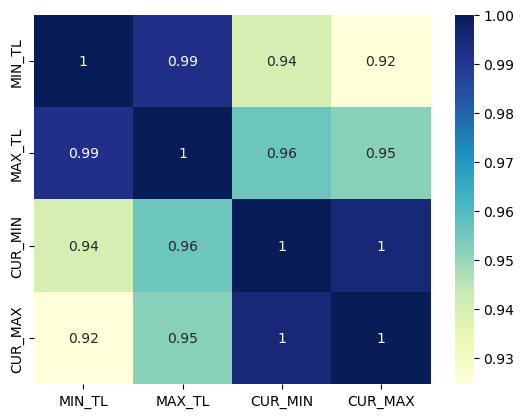

In [25]:
# Korelasyon ısı haritası. Bağımsız değişkenler kategorik olduğundan istenen sonucu elde edemeyiz
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")
plt.show()

In [45]:
# Her değişken için eksik değer sayıları
df.isnull().sum()

LEVEL                           0
POSITION                        0
TECH_STACK                      1
EXPERIENCE                      0
GENDER                          0
COMPANY                         0
COMPANY_SIZE                    0
WORK_TYPE                       0
CITY                            0
CURRENCY                        0
SALARY_FOR_OTHER_CURRENCY    4493
SALARY_FOR_TL_CURRENCY        533
MIN_TL                          0
MAX_TL                          0
CUR_MIN                         0
CUR_MAX                         0
SALARY_AVG_TL                   0
dtype: int64

In [56]:
# Bir değişkeni eksik değer içeren satırlar
df[df["SALARY_FOR_TL_CURRENCY"].isna()]

,LEVEL,POSITION,TECH_STACK,EXPERIENCE,GENDER,COMPANY,COMPANY_SIZE,WORK_TYPE,CITY,CURRENCY,SALARY_FOR_OTHER_CURRENCY,SALARY_FOR_TL_CURRENCY,MIN_TL,MAX_TL,CUR_MIN,CUR_MAX,SALARY_AVG_TL
7,Middle,BACK-END DEVELOPER,".Net, JavaScript | Html | Css, Angular, React ...",3 - 5 Yıl,Erkek,Startup,100 - 250 Kişi,Remote,Yurt Dışı,$ - Dolar,10.000 ve üzeri,NaN,186300.0,204911.37,10000.0,10999.0,195605
13,Junior,MOBILE APPLICATION DEVELOPER,"Swift / Objective C, Flutter",1 - 3 Yıl,Erkek,Startup,1 - 10 Kişi,Remote,Yurt Dışı,$ - Dolar,2.000 - 2.999,NaN,37260.0,55871.37,2000.0,2999.0,46565
16,Senior,FULL STACK DEVELOPER,"Php, Swift / Objective C",10 - 14 Yıl,Erkek,E-Ticaret,1 - 10 Kişi,Remote,İstanbul,$ - Dolar,2.000 - 2.999,NaN,37260.0,55871.37,2000.0,2999.0,46565
21,Senior,TEAM / TECH LEAD,Python,15 Yıl ve üzeri,Erkek,Kurumsal,250+,Hibrit,Sydney,$ - Dolar,10.000 ve üzeri,NaN,186300.0,204911.37,10000.0,10999.0,195605
22,Senior,FULL STACK DEVELOPER,"Php, Angular",7 - 10 Yıl,Erkek,Oyun,100 - 250 Kişi,Remote,İstanbul,€ - Euro,2.000 - 2.999,NaN,38940.0,58390.53,2000.0,2999.0,48665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,Middle,BACK-END DEVELOPER,Java,7 - 10 Yıl,Erkek,Kurumsal,250+,Hibrit,Ankara,$ - Dolar,5.000 - 5.999,NaN,93150.0,111761.37,5000.0,5999.0,102455
4996,Junior,FULL STACK DEVELOPER,"JavaScript | Html | Css, Perl, MySQL",1 - 3 Yıl,Erkek,Kurumsal,25 - 50 Kişi,Geçici Remote,Yurt Dışı,€ - Euro,2.000 - 2.999,NaN,38940.0,58390.53,2000.0,2999.0,48665
5004,Senior,SOFTWARE DEVELOPMENT MANAGER,"Java, Go",15 Yıl ve üzeri,Erkek,Startup,25 - 50 Kişi,Hibrit,İstanbul,$ - Dolar,4.000 - 4.999,NaN,74520.0,93131.37,4000.0,4999.0,83825
5017,Middle,BACK-END DEVELOPER,Java,1 - 3 Yıl,Erkek,Kurumsal,250+,Hibrit,Yurt Dışı,$ - Dolar,4.000 - 4.999,NaN,74520.0,93131.37,4000.0,4999.0,83825


In [49]:
# Bu değişken kardinal bir kategorik değişken. Ya sınıf sayısını ciddi oranda düşürmeli ya da regresyon preoblemi olarak ele almalı!
df["SALARY_FOR_TL_CURRENCY"].value_counts

<bound method IndexOpsMixin.value_counts of 0       15.000 TL - 15.999 TL
1         8.000 TL - 8.999 TL
2       15.000 TL - 15.999 TL
3       10.000 TL - 10.999 TL
4         5.000 TL - 5.999 TL
                ...          
5021      8.000 TL - 8.999 TL
5022    10.000 TL - 10.999 TL
5023      8.000 TL - 8.999 TL
5024    25.000 TL - 25.999 TL
5025    11.000 TL - 11.999 TL
Name: SALARY_FOR_TL_CURRENCY, Length: 5026, dtype: object>

In [116]:
# Türkiye şehirler listesi
sehirler = ["Adana", "Adıyaman", "Afyon", "Ağrı", "Amasya", "Ankara", "Antalya", "Artvin", "Aydın", "Balıkesir", "Bilecik", "Bingöl", "Bitlis", "Bolu", "Burdur", "Bursa", "Çanakkale", "Çankırı", "Çorum", "Denizli", "Diyarbakır", "Edirne", "Elazığ", "Erzincan", "Erzurum", "Eskişehir", "Gaziantep", "Giresun", "Gümüşhane", "Hakkari", "Hatay", "Isparta", "Mersin", "İstanbul", "İzmir", "Kars", "Kastamonu", "Kayseri", "Kırklareli", "Kırşehir", "Kocaeli", "Konya", "Kütahya", "Malatya", "Manisa", "Kahramanmaraş", "Mardin", "Muğla", "Muş", "Nevşehir", "Niğde", "Ordu", "Rize", "Sakarya", "Samsun", "Siirt", "Sinop", "Sivas", "Tekirdağ", "Tokat", "Trabzon", "Tunceli", "Şanlıurfa", "Uşak", "Van", "Yozgat", "Zonguldak", "Aksaray", "Bayburt", "Karaman", "Kırıkkale", "Batman", "Şırnak", "Bartın", "Ardahan", "Iğdır", "Yalova", "Karabük", "Kilis", "Osmaniye", "Düzce"]

In [117]:
# CITY değişkeninde baş ve sonlardaki boşlukları silelim
df['CITY'] = df['CITY'].str.strip()

In [118]:
# CITY değişkeninin değerlerini standart hale getirelim
df['CITY'] = [il.capitalize() for il in df["CITY"].values]

In [119]:
# Değişkende bulunan tüm eşsiz sınıflar
df["CITY"].unique()

array(['İstanbul', 'Kocaeli', 'Yurt dışı', 'Ankara', 'Sydney', 'İzmir',
       'Gaziantep', 'Konya', 'Bolu', 'Kayseri', 'Malatya', 'Antalya',
       'Diğer', 'Krakow', 'Miami', 'Muğla', 'Eskişehir', 'İngiltere',
       'Denizli', 'Çanakkale', 'Düsseldorf', 'Düzce', 'Edirne', 'Bursa',
       'Köln', 'Samsun', 'Amsterdam', 'Hatay', 'Çorum', 'Kırklareli',
       'Adana', 'Belçika', 'Stuttgart', 'Luxembourg', 'Tokat', 'Utrecht',
       'Isviçre', 'Seattle', 'Nürnberg', 'Mersin', 'Tekirdağ',
       'San fransisco', 'Sakarya', 'Londra', 'Stokholm', 'Tallinn', 'Abd',
       'Yalova', 'Şanlıurfa', 'Anadolu', 'Berlin', 'Trabzon', 'Bandırma',
       'Washington', 'Şırnak', 'Erzurum', 'Zonguldak', 'Singapur',
       'Manisa', 'Kaliforniya', 'Kütahya', 'Kahramanmaraş', 'Niğde',
       'Aydın', 'Ukrayna', 'Paris', 'Ordu', 'Elazığ', 'İtalya', 'Letonya',
       'Sivas', 'Dubai', 'İzmit', 'Indianapolis', 'Costarica',
       'Bratislava', 'Edremit', 'Zurich', 'Sofia', 'Dublin', 'Almanya',
       'Diyar

In [120]:
# Değişkendeki eşsiz sınıf sayısı
df["CITY"].nunique()

116

In [121]:
yd = [il for il in df["CITY"].unique() if il not in sehirler]
set(yd)     # İlçeler, << kaçak iller >> yurt dışı yerler ile "yurt dışı" var !

{'Abd',
 'Alanya',
 'Almanya',
 'Amsterdam',
 'Anadolu',
 'Aydin',
 'Bandırma',
 'Belçika',
 'Berlin',
 'Bratislava',
 'Brüksel',
 'Connecticut',
 'Costarica',
 'Deni̇zli̇',
 'Diğer',
 'Dubai',
 'Dublin',
 'Düsseldorf',
 'Edremit',
 'Eskisehir',
 'Eski̇şehi̇r',
 'Helsinki',
 'Indianapolis',
 'Irvine',
 'Isviçre',
 'Kaliforniya',
 'Kiev',
 'Kktc',
 'Kopenhag',
 'Krakow',
 'Kuzey amerika',
 'Köln',
 'Letonya',
 'Londra',
 'Los angeles',
 'Luxembourg',
 'Miami',
 'Misir',
 'Montreuil',
 'Münih',
 'New york',
 'Nürnberg',
 'Oslo',
 'Palo alto',
 'Paris',
 'San fransisco',
 'Seattle',
 'Singapur',
 'Sofia',
 'Stokholm',
 'Stuttgart',
 'Sydney',
 'Tallinn',
 'Texas',
 'Ukrayna',
 'Utrecht',
 'Varşova',
 'Washington',
 'Yurt dışı',
 'Zurich',
 'İngiltere',
 'İsviçre',
 'İtalya',
 'İzmit'}

In [130]:
# ! ! Başka IDE'lerde deneme lazım ! !
"Eski̇şehi̇r" in sehirler

False

Yapılacaklar
- İzmit -> Kocaeli
- Eskisehir == Eskişehir
- Denizli ...

In [52]:
df.columns

Index(['LEVEL', 'POSITION', 'TECH_STACK', 'EXPERIENCE', 'GENDER', 'COMPANY',
       'COMPANY_SIZE', 'WORK_TYPE', 'CITY', 'CURRENCY',
       'SALARY_FOR_OTHER_CURRENCY', 'SALARY_FOR_TL_CURRENCY', 'MIN_TL',
       'MAX_TL', 'CUR_MIN', 'CUR_MAX', 'SALARY_AVG_TL'],
      dtype='object')

In [122]:
# Sınıflar arası fark varsa (ordinal kategorik değişkenler)- Label Encoding
le_cols = ["LEVEL", "EXPERIENCE", "COMPANY_SIZE"]

# Sınıflar arası fark yoksa (nominal kategorik değişkenler) - One Hot Encoding
ole_cols = ["POSITION", "TECH_STACK", "GENDER", "COMPANY", "WORK_TYPE", "CITY"]

# Çok fazla sınıfa sahip değişkenlerde 10'dan az sınıfları birleştirmeyi düşünüyoruz
rare_cols = ["TECH_STACK", "CITY"]      # CITY eklenmese de olur

In [123]:
# Veri setinde işimize yaramayan değişkenler
unnecessary_cols = [col for col in df.columns if col not in (le_cols + ole_cols + [target_col])]
unnecessary_cols

['CURRENCY',
 'SALARY_FOR_OTHER_CURRENCY',
 'SALARY_FOR_TL_CURRENCY',
 'MIN_TL',
 'MAX_TL',
 'CUR_MIN',
 'CUR_MAX']

In [124]:
# Veri setinden bu değişkenleri dışlayıp yeni bir df oluşturalım
data = df.drop(unnecessary_cols, axis=1)

In [125]:
data.head()

,LEVEL,POSITION,TECH_STACK,EXPERIENCE,GENDER,COMPANY,COMPANY_SIZE,WORK_TYPE,CITY,SALARY_AVG_TL
0,Middle,BACK-END DEVELOPER,Php,3 - 5 Yıl,Erkek,Startup,25 - 50 Kişi,Hibrit,İstanbul,15499
1,Junior,FRONT-END DEVELOPER,React,0 - 1 Yıl,Erkek,Startup,10 - 25 Kişi,Hibrit,İstanbul,8499
2,Middle,BACK-END DEVELOPER,.Net,1 - 3 Yıl,Erkek,Outsource,10 - 25 Kişi,Remote,İstanbul,15499
3,Junior,FULL STACK DEVELOPER,"Java, JavaScript | Html | Css, React, React Na...",1 - 3 Yıl,Erkek,Startup,10 - 25 Kişi,Hibrit,İstanbul,10499
4,Junior,BACK-END DEVELOPER,".Net, JavaScript | Html | Css",0 - 1 Yıl,Erkek,Kurumsal,250+,Geçici Hibrit,Kocaeli,5499


CITY bağımsız değişken olarak kabul edilecekse yurt içi ve yurt dışı şeklinde nominal iki sınıfa ayrılabilir.


In [ ]:
# Şimdi sıra encoding işlemlerinde

In [ ]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)